In [20]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de texto
import re
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modelos de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Configuraciones
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

nlp = spacy.load('es_core_news_sm')
nltk.download('stopwords')

# Descargar recursos necesarios de NLTK
try:
    nltk.download('stopwords')
    nltk.download('punkt')
except:
    print("Error al descargar recursos de NLTK, pero continuaremos con el análisis")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aberr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aberr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aberr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
data = pd.read_csv('../data.csv')
data.head()


,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [22]:
#Objetivo 
#Predecir el sentimiento de un comentario 
#En base al texto de los usuarios
#Utilizando modelos de machine learning

## Particion de datos
#Separar los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

x = data['text']
y = data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_test.shape)


(2072,)
(518,)


In [23]:
#Preprocesamiento del texto
import re

def preprocess_text(text: str) -> str:
    if isinstance(text, str):
        # Convertir a minúsculas
        text = text.lower()
        
        # Eliminar URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Eliminar menciones (@usuario)
        text = re.sub(r'@\w+', '', text)
        
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)
        
        # Eliminar caracteres especiales, números y puntuaciones
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        
        # Eliminar espacios múltiples
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    else:
        return ''

x_train_clean = x_train.apply(preprocess_text)
x_test_clean = x_test.apply(preprocess_text)


In [24]:
# Cargar stopwords en español
spanish_stopwords = stopwords.words('spanish')

# Añadir algunas stopwords adicionales específicas 
additional_stopwords = ['si', 'xq', 'q', 'x', 'k', 'qe', 'pq', 'rt', 'xa', 'xo', 'jaja', 'jajaja', 'jajajaja']
spanish_stopwords.extend(additional_stopwords)


# Función para aplicar lematización y eliminar stopwords
def tokenize_and_lemmatize(text):
    if isinstance(text, str):
        # Procesar texto con spaCy
        doc = nlp(text)

        # Eliminar stopwords y puntuación, aplicar lematización
        lemmas = [token.lemma_ for token in doc if token.lemma_.lower() not in spanish_stopwords and len(token.lemma_) > 2 and not token.is_punct]

        return ' '.join(lemmas)
    else:
        return ''
    

# Aplicar tokenización y lematización
x_train_final = x_train_clean.apply(tokenize_and_lemmatize)
x_test_final = x_test_clean.apply(tokenize_and_lemmatize)




In [25]:
# Inicializar el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limitar a las 5000 características más relevantes
    min_df=2,           # Ignorar términos que aparecen en menos de 2 documentos
    max_df=0.85,        # Ignorar términos que aparecen en más del 85% de los documentos
    ngram_range=(1, 2)  # Considerar unigramas y bigramas
)

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_final)
x_test_tfidf = tfidf_vectorizer.transform(x_test_final)


In [26]:
#Funcion para evaluar el modelo

def evaluate_model(model, x_train, x_test, y_train, y_test, model_name):
    # Entrenar el modelo
    model.fit(x_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(x_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Imprimir resultados
    print(f"\n--- Resultados del modelo: {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Imprimir informe de clasificación detallado
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.tight_layout()
    plt.show()
    
    return model, accuracy, precision, recall, f1


--- Resultados del modelo: Naive Bayes ---
Accuracy: 0.5502
Precision: 0.6267
Recall: 0.5502
F1 Score: 0.5269

Informe de clasificación:
              precision    recall  f1-score   support

      joyful       0.67      0.23      0.34        61
         mad       0.67      0.66      0.67       106
    peaceful       0.43      0.90      0.58       135
    powerful       0.75      0.49      0.59        92
         sad       0.71      0.37      0.49        68
      scared       0.67      0.18      0.28        56

    accuracy                           0.55       518
   macro avg       0.65      0.47      0.49       518
weighted avg       0.63      0.55      0.53       518



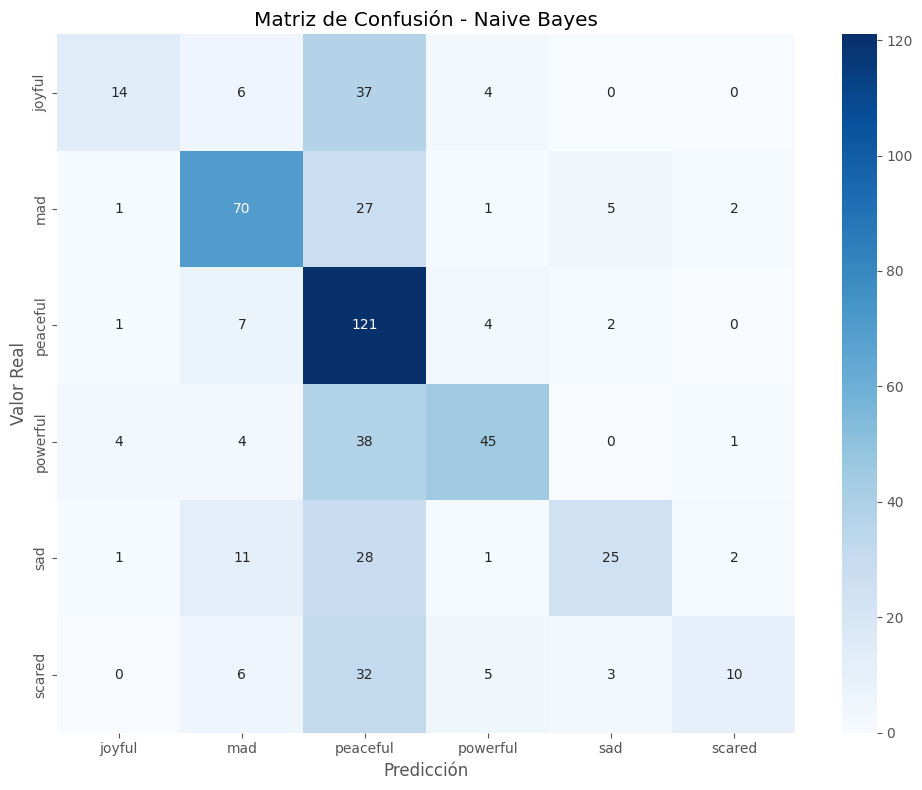

In [27]:
# Inicializar el modelo Multinomial Naive Bayes
nb_model = MultinomialNB()

# Entrenar y evaluar el modelo
nb_results = evaluate_model(nb_model, x_train_tfidf, x_test_tfidf, y_train, y_test, "Naive Bayes")


--- Resultados del modelo: SVM ---
Accuracy: 0.6834
Precision: 0.6867
Recall: 0.6834
F1 Score: 0.6812

Informe de clasificación:
              precision    recall  f1-score   support

      joyful       0.65      0.52      0.58        61
         mad       0.70      0.70      0.70       106
    peaceful       0.67      0.80      0.73       135
    powerful       0.65      0.68      0.67        92
         sad       0.68      0.59      0.63        68
      scared       0.82      0.66      0.73        56

    accuracy                           0.68       518
   macro avg       0.69      0.66      0.67       518
weighted avg       0.69      0.68      0.68       518



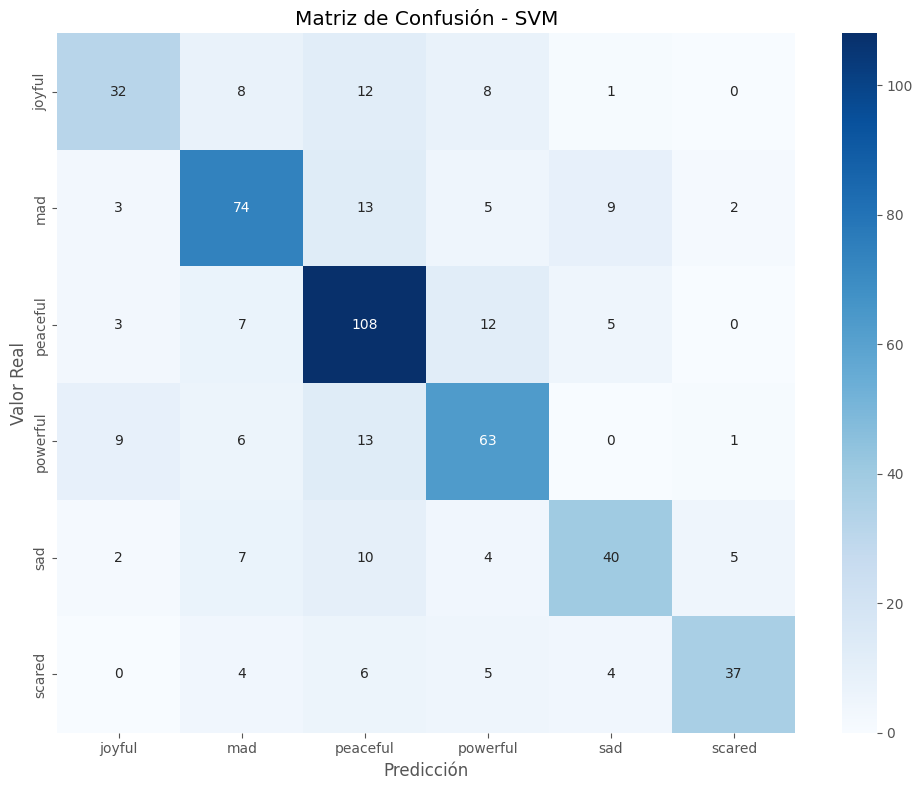

In [28]:
# Inicializar el modelo SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Entrenar y evaluar el modelo
svm_results = evaluate_model(svm_model, x_train_tfidf, x_test_tfidf, y_train, y_test, "SVM")


--- Resultados del modelo: KNN ---
Accuracy: 0.5174
Precision: 0.5844
Recall: 0.5174
F1 Score: 0.5136

Informe de clasificación:
              precision    recall  f1-score   support

      joyful       0.59      0.26      0.36        61
         mad       0.42      0.75      0.53       106
    peaceful       0.77      0.46      0.57       135
    powerful       0.42      0.64      0.51        92
         sad       0.62      0.46      0.53        68
      scared       0.68      0.38      0.48        56

    accuracy                           0.52       518
   macro avg       0.58      0.49      0.50       518
weighted avg       0.58      0.52      0.51       518



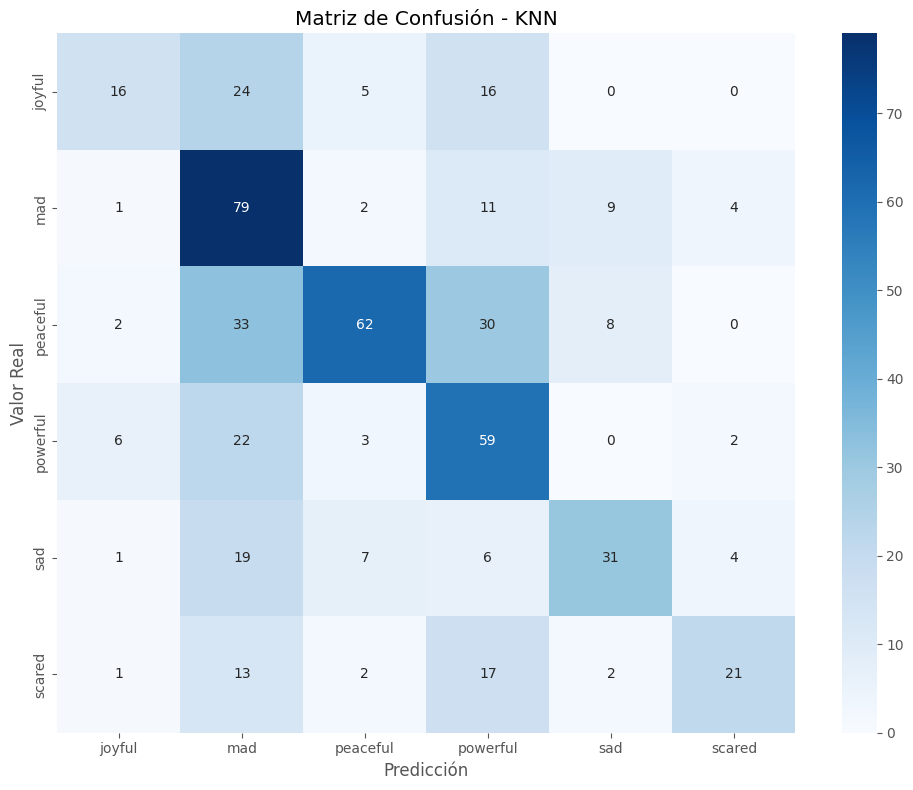

In [29]:
# Inicializar el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Entrenar y evaluar el modelo
knn_results = evaluate_model(knn_model, x_train_tfidf, x_test_tfidf, y_train, y_test, "KNN")


--- Resultados del modelo: RandomForest ---
Accuracy: 0.7394
Precision: 0.7433
Recall: 0.7394
F1 Score: 0.7393

Informe de clasificación:
              precision    recall  f1-score   support

      joyful       0.75      0.66      0.70        61
         mad       0.70      0.73      0.71       106
    peaceful       0.72      0.81      0.77       135
    powerful       0.78      0.71      0.74        92
         sad       0.69      0.74      0.71        68
      scared       0.85      0.73      0.79        56

    accuracy                           0.74       518
   macro avg       0.75      0.73      0.74       518
weighted avg       0.74      0.74      0.74       518



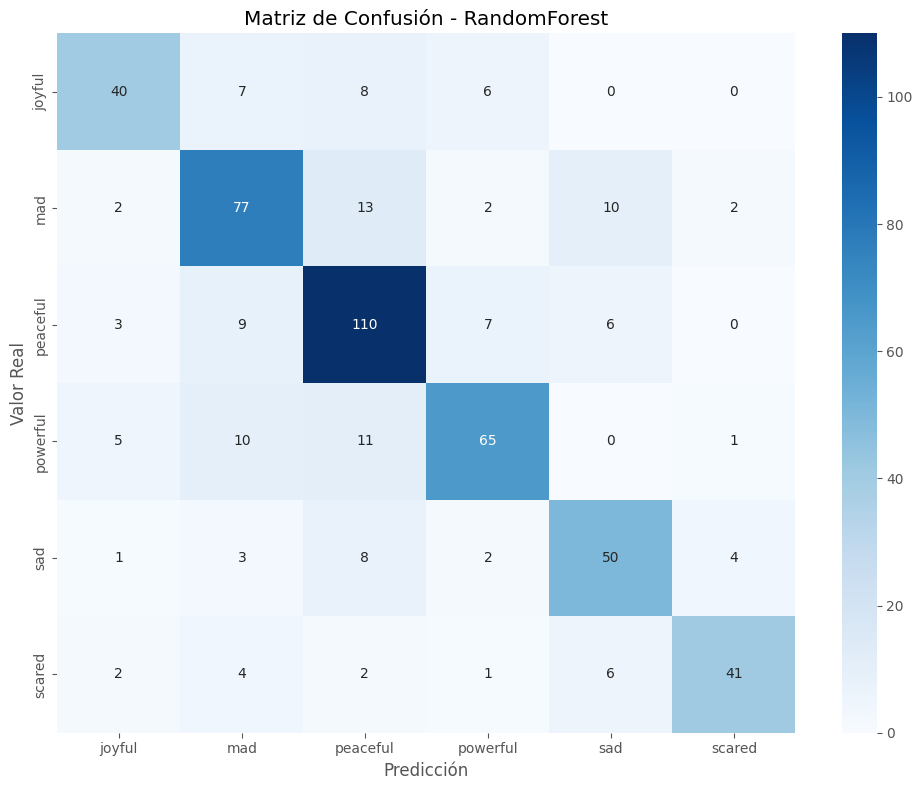

In [30]:
from sklearn.ensemble import RandomForestClassifier
# Inicializar el modelo RandomForest
rf_model = RandomForestClassifier(random_state = 123)


# Entrenar y evaluar el modelo
rf_results = evaluate_model(rf_model, x_train_tfidf, x_test_tfidf, y_train, y_test, "RandomForest")


--- Resultados del modelo: CatBoost ---
Accuracy: 0.7761
Precision: 0.7927
Recall: 0.7761
F1 Score: 0.7762

Informe de clasificación:
              precision    recall  f1-score   support

      joyful       0.83      0.64      0.72        61
         mad       0.89      0.73      0.80       106
    peaceful       0.67      0.90      0.77       135
    powerful       0.85      0.73      0.78        92
         sad       0.75      0.74      0.74        68
      scared       0.84      0.86      0.85        56

    accuracy                           0.78       518
   macro avg       0.80      0.76      0.78       518
weighted avg       0.79      0.78      0.78       518



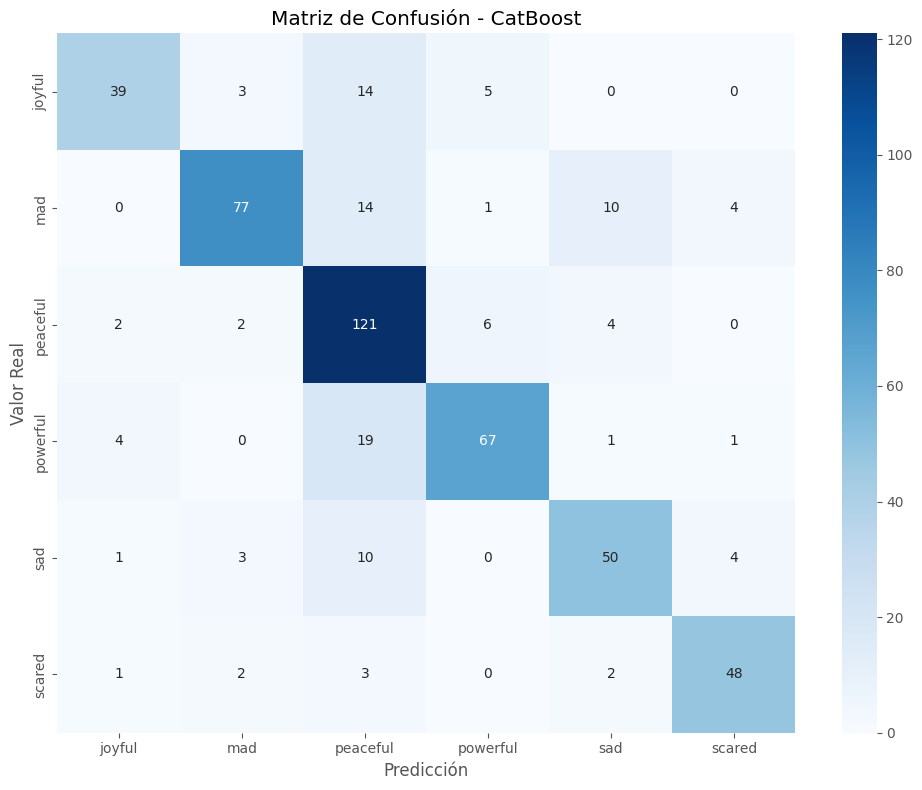

In [31]:
from catboost import CatBoostClassifier

# Inicializar el modelo Catboost
cb_model = CatBoostClassifier(random_state = 123, verbose = False)


# Entrenar y evaluar el modelo
cb_results = evaluate_model(cb_model, x_train_tfidf, x_test_tfidf, y_train, y_test, "CatBoost")


--- Resultados del modelo: Regresión Logística ---
Accuracy: 0.6371
Precision: 0.6576
Recall: 0.6371
F1 Score: 0.6267

Informe de clasificación:
              precision    recall  f1-score   support

      joyful       0.67      0.36      0.47        61
         mad       0.70      0.68      0.69       106
    peaceful       0.56      0.86      0.67       135
    powerful       0.67      0.65      0.66        92
         sad       0.70      0.56      0.62        68
      scared       0.73      0.39      0.51        56

    accuracy                           0.64       518
   macro avg       0.67      0.58      0.60       518
weighted avg       0.66      0.64      0.63       518



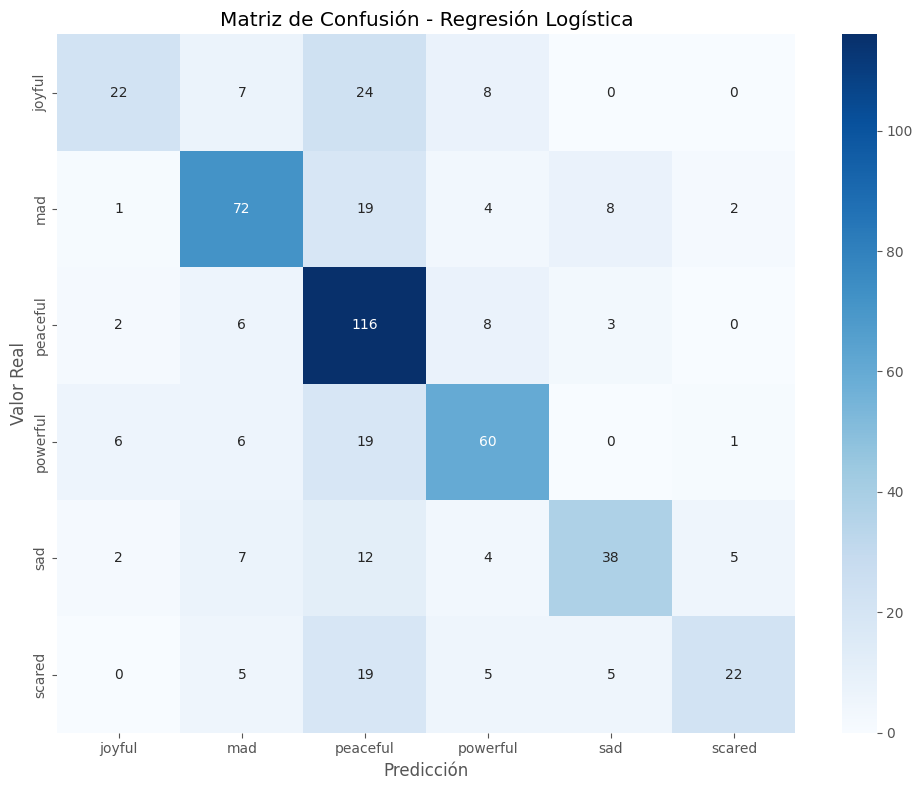

In [32]:
from sklearn.linear_model import LogisticRegression

# Inicializar el modelo Catboost
rl_model = LogisticRegression()


# Entrenar y evaluar el modelo
rl_results = evaluate_model(rl_model, x_train_tfidf, x_test_tfidf, y_train, y_test, "Regresión Logística")

Comparación de modelos:
                Modelo  Accuracy  Precision    Recall  F1 Score
0          Naive Bayes  0.550193   0.626715  0.550193  0.526857
1                  SVM  0.683398   0.686748  0.683398  0.681217
2                  KNN  0.517375   0.584365  0.517375  0.513556
3        Random Forest  0.739382   0.743318  0.739382  0.739254
4             CatBoost  0.776062   0.792686  0.776062  0.776180
5  Regresion Logistica  0.637066   0.657593  0.637066  0.626717


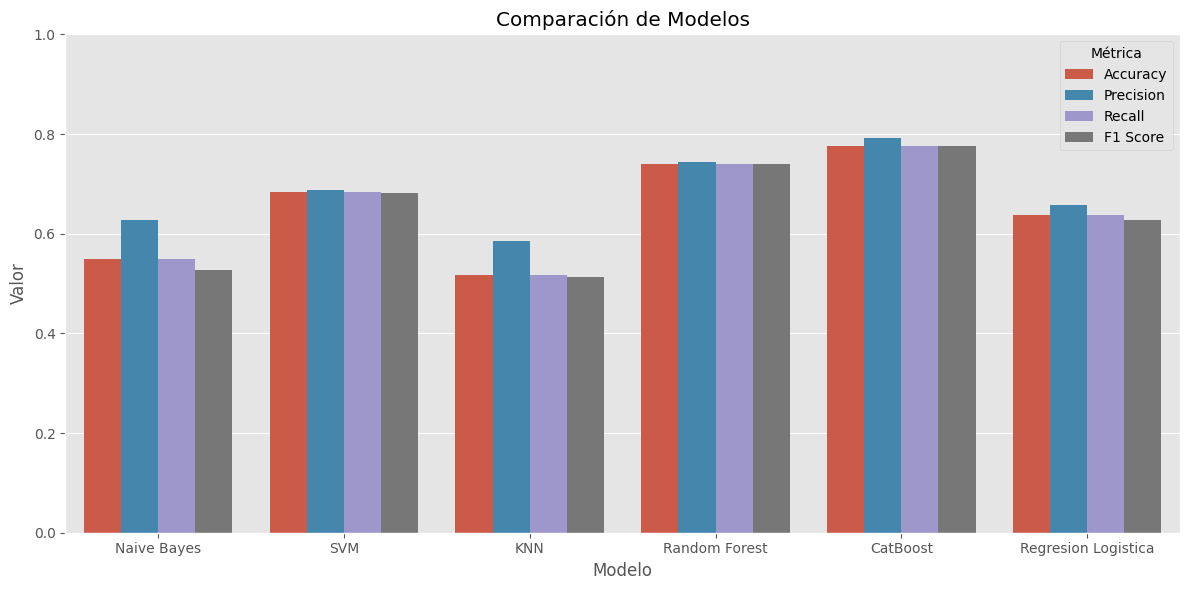

In [33]:
# Compilar resultados
models = ['Naive Bayes', 'SVM', 'KNN', 'Random Forest', 'CatBoost', 'Regresion Logistica']
accuracy = [nb_results[1], svm_results[1], knn_results[1], rf_results[1], cb_results[1], rl_results[1]]
precision = [nb_results[2], svm_results[2], knn_results[2], rf_results[2], cb_results[2], rl_results[2]]
recall = [nb_results[3], svm_results[3], knn_results[3], rf_results[3], cb_results[3], rl_results[3]]
f1 = [nb_results[4], svm_results[4], knn_results[4], rf_results[4], cb_results[4], rl_results[4]]

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Modelo': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Mostrar tabla de resultados
print("Comparación de modelos:")
print(results_df)

# Visualizar comparación
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
results_melted = pd.melt(results_df, id_vars='Modelo', value_vars=metrics, 
                         var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12, 6))
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=results_melted)
plt.title('Comparación de Modelos')
plt.ylim(0, 1)
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()

In [37]:
# Identificar el mejor modelo basado en F1 Score
'''
best_model_index = results_df['F1 Score'].idxmax()
best_model_name = results_df.loc[best_model_index, 'Modelo']
print(f"El mejor modelo basado en F1 Score es: {best_model_name}")

# Configurar pipeline y parámetros para optimización
if best_model_name == 'Naive Bayes':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])
    
    parameters = {
        'tfidf__max_features': [3000, 5000, 7000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__alpha': [0.1, 0.5, 1.0]
    }
    
elif best_model_name == 'SVM':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', SVC(random_state=42))
    ])
    
    parameters = {
        'tfidf__max_features': [3000, 5000, 7000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.1, 1.0, 10.0],
        'clf__kernel': ['linear', 'rbf']
    }
    
elif best_model_name == 'KNN':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', KNeighborsClassifier())
    ])
    
    parameters = {
        'tfidf__max_features': [3000, 5000, 7000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    }
elif best_model_name == 'Random Forest':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    parameters = {
        'tfidf__max_features': [3000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20]
    }
elif best_model_name == 'CatBoost':
    # Crear directorio temporal para CatBoost
    import os
    temp_dir = 'temp_catboost'
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', CatBoostClassifier(
            random_state=42,
            verbose=False,
            train_dir=temp_dir,
            allow_writing_files=False,  # Evitar escribir archivos
            loss_function='MultiClass',
            eval_metric='Accuracy',
            save_snapshot=False  # Evitar guardar snapshots
        ))
    ])
    parameters = {
        'tfidf__max_features': [3000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__iterations': [100, 200],
        'clf__learning_rate': [0.05, 0.1],
        'clf__depth': [4, 6]  # Agregamos profundidad del árbol
    }

elif best_model_name == 'Regresión Logística':
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])
    parameters = {
        'tfidf__max_features': [3000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.1, 1.0, 10.0],
        'clf__penalty': ['l2']
    }

# Realizar búsqueda de mejores parámetros con validación cruzada
grid_search = GridSearchCV(
    pipeline, 
    parameters, 
    cv=3, 
    scoring='f1_weighted', 
    n_jobs=-1,
    verbose=1  # Agregamos verbose para ver el progreso
)

# Entrenar el modelo
print("\nIniciando entrenamiento del modelo...")
grid_search.fit(x_train, y_train)

# Imprimir mejores parámetros
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo optimizado
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(x_test)

print("\nResultados del modelo optimizado:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimized, average='weighted'):.4f}")

print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred_optimized))

# Limpiar el directorio temporal después de terminar
if best_model_name == 'CatBoost':
    import shutil
    try:
        shutil.rmtree(temp_dir)
    except:
        pass'''

El mejor modelo basado en F1 Score es: CatBoost

Iniciando entrenamiento del modelo...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


KeyboardInterrupt: 

In [45]:
import pickle

pickle.dump(cb_model, open("model.pkl", "wb"))


In [46]:
pickle.dump(tfidf_vectorizer, open("vectorizer.pkl", "wb"))



In [18]:
'''def predict_sentiment(text, model=best_model):
    # Preprocesar el texto
    clean_text = preprocess_text(text)
    processed_text = tokenize_and_lemmatize(clean_text)
    
    # Predecir
    prediction = model.predict([processed_text])[0]
    
    return prediction

# Probar con algunos ejemplos
test_texts = [
    "¡Estoy muy feliz con mi nuevo trabajo!",
    "Me siento triste y decepcionado por los resultados",
    "Estoy preocupado por lo que pueda pasar mañana",
    "Ese comentario me hizo enojar mucho"
]

print("\nPredicciones para ejemplos nuevos:")
for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"Texto: {text}")
    print(f"Sentimiento predicho: {sentiment}")
    print("-" * 80)'''


Predicciones para ejemplos nuevos:


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="feliz nuevo trabajo": Cannot convert 'feliz nuevo trabajo' to float